# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

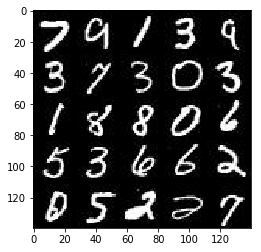

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

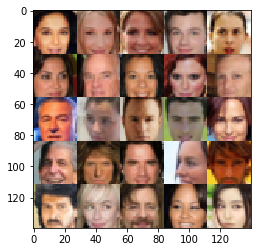

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        x1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_w, img_h, img_d = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    samples = []
    steps = 0
    print_every = 10
    show_every = 100
    # figsize=(5,5)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 # from [-0.5, 0.5] to [-1, 1]
                steps += 1

                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_d, data_image_mode)

        saver.save(sess, './generator.ckpt')
    
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6428... Generator Loss: 0.3014
Epoch 1/2... Discriminator Loss: 0.0578... Generator Loss: 5.6612
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.4605
Epoch 1/2... Discriminator Loss: 0.1696... Generator Loss: 2.9757
Epoch 1/2... Discriminator Loss: 0.2412... Generator Loss: 2.1081
Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 2.3667
Epoch 1/2... Discriminator Loss: 0.6732... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.3469... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.4006


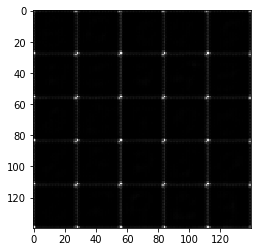

Epoch 1/2... Discriminator Loss: 0.8065... Generator Loss: 1.3172
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.9314
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 0.8843
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.5565
Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 2.8001
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.2997... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 0.5464


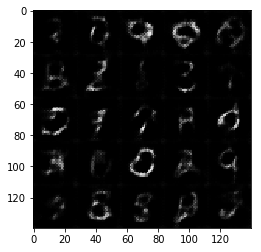

Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.4956... Generator Loss: 0.3712
Epoch 1/2... Discriminator Loss: 1.7958... Generator Loss: 2.8057
Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.0289... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.7839
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 1.0116
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.3567
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 0.9075


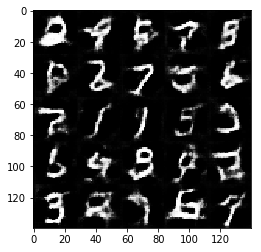

Epoch 1/2... Discriminator Loss: 1.3923... Generator Loss: 0.3943
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 1.4265
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 1.3256
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 1.1358
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 0.9195... Generator Loss: 1.3341
Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.3122
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.7789


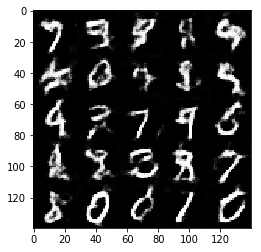

Epoch 1/2... Discriminator Loss: 0.8191... Generator Loss: 1.6591
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 0.5656
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 0.9059... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 1.4430... Generator Loss: 0.3560
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 0.8903
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 1.5443... Generator Loss: 2.8017
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.8439


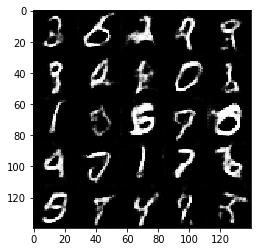

Epoch 1/2... Discriminator Loss: 2.0281... Generator Loss: 0.2091
Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 0.8267... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.4281
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 1.5080
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 2.5913... Generator Loss: 4.1203
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 0.8393


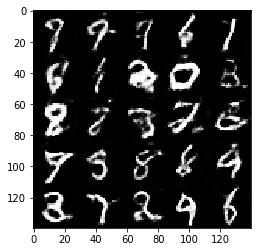

Epoch 1/2... Discriminator Loss: 0.9009... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 0.7382
Epoch 1/2... Discriminator Loss: 1.0013... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.6468
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.0728
Epoch 1/2... Discriminator Loss: 1.2872... Generator Loss: 1.5875
Epoch 1/2... Discriminator Loss: 0.8042... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 0.5872


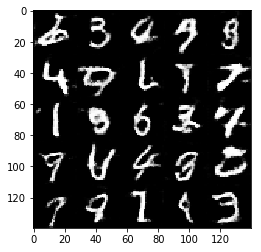

Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.4724
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.5723
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.5352
Epoch 1/2... Discriminator Loss: 0.9522... Generator Loss: 0.9276
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.6210
Epoch 1/2... Discriminator Loss: 0.7598... Generator Loss: 1.2258
Epoch 1/2... Discriminator Loss: 0.8385... Generator Loss: 1.1422
Epoch 1/2... Discriminator Loss: 0.9863... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.5617... Generator Loss: 0.3199


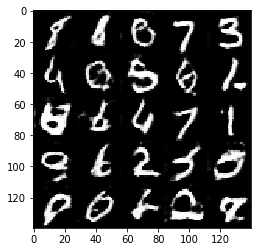

Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 0.7819
Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.1405
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 0.8461... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 2.0569
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.2686... Generator Loss: 2.5084
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 0.7508... Generator Loss: 1.5512


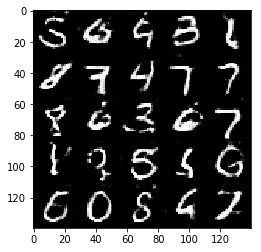

Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 2.4918... Generator Loss: 0.1525
Epoch 1/2... Discriminator Loss: 1.1287... Generator Loss: 0.7970
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.6844
Epoch 2/2... Discriminator Loss: 0.5819... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 0.6908... Generator Loss: 1.6114
Epoch 2/2... Discriminator Loss: 0.5020... Generator Loss: 1.6338
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.5737
Epoch 2/2... Discriminator Loss: 0.9542... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 0.9155... Generator Loss: 0.9637


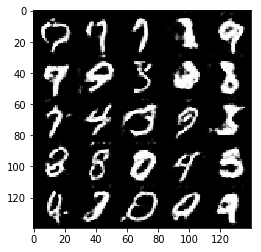

Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.6981
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.2720
Epoch 2/2... Discriminator Loss: 0.9500... Generator Loss: 0.9520
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 1.7928... Generator Loss: 0.2597
Epoch 2/2... Discriminator Loss: 1.8134... Generator Loss: 0.2627
Epoch 2/2... Discriminator Loss: 0.9856... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.0030... Generator Loss: 0.7256
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 0.7685
Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 0.9500


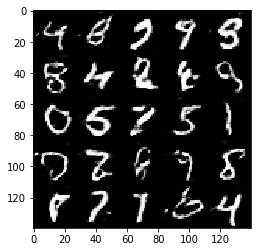

Epoch 2/2... Discriminator Loss: 0.8461... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.5023
Epoch 2/2... Discriminator Loss: 1.9219... Generator Loss: 0.2185
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.6367
Epoch 2/2... Discriminator Loss: 0.6641... Generator Loss: 1.8791
Epoch 2/2... Discriminator Loss: 1.2902... Generator Loss: 0.5083
Epoch 2/2... Discriminator Loss: 1.7220... Generator Loss: 0.3075
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.5543
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 0.9136


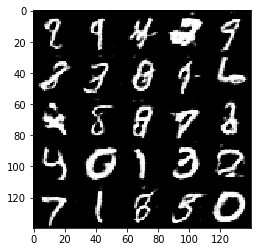

Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.7444
Epoch 2/2... Discriminator Loss: 1.5914... Generator Loss: 0.3255
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.0734
Epoch 2/2... Discriminator Loss: 1.0145... Generator Loss: 0.7159
Epoch 2/2... Discriminator Loss: 0.8121... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 0.9331... Generator Loss: 0.7653
Epoch 2/2... Discriminator Loss: 0.8591... Generator Loss: 0.9966


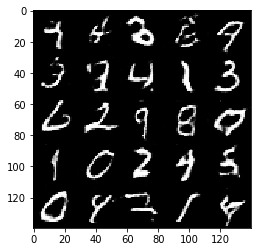

Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 0.6906
Epoch 2/2... Discriminator Loss: 0.6754... Generator Loss: 2.2977
Epoch 2/2... Discriminator Loss: 0.7849... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.6645
Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.4125
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 0.6160
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 1.8537
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.8853
Epoch 2/2... Discriminator Loss: 0.9820... Generator Loss: 0.7351


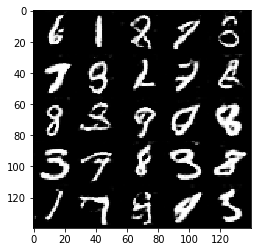

Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 0.9349... Generator Loss: 0.8609
Epoch 2/2... Discriminator Loss: 1.8406... Generator Loss: 0.3920
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 0.8773
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.4582
Epoch 2/2... Discriminator Loss: 0.9599... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 0.9640... Generator Loss: 0.7398
Epoch 2/2... Discriminator Loss: 0.9384... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.1219... Generator Loss: 0.6051


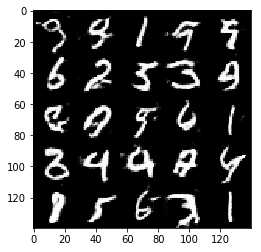

Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.5756
Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 0.5395... Generator Loss: 1.5666
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.6261
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.1330
Epoch 2/2... Discriminator Loss: 0.5908... Generator Loss: 1.3342
Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 1.8821
Epoch 2/2... Discriminator Loss: 0.6120... Generator Loss: 1.9484


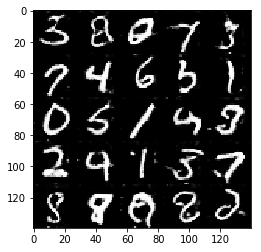

Epoch 2/2... Discriminator Loss: 1.5817... Generator Loss: 0.3625
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.4812
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.6997
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 0.9954
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 0.6083... Generator Loss: 1.2513
Epoch 2/2... Discriminator Loss: 0.8291... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.2125


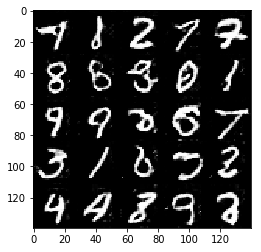

Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.6490
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.1033
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 1.9376
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.6519
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 0.6725... Generator Loss: 1.7674
Epoch 2/2... Discriminator Loss: 1.0493... Generator Loss: 0.5928
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.4316


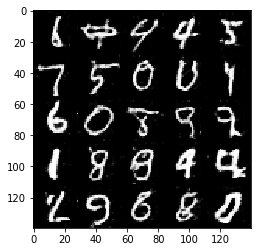

Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 2.2999
Epoch 2/2... Discriminator Loss: 1.4968... Generator Loss: 0.3629
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.7298
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.6243
Epoch 2/2... Discriminator Loss: 1.4179... Generator Loss: 0.4305
Epoch 2/2... Discriminator Loss: 0.6453... Generator Loss: 1.1908
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.6044


In [24]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses_mnist = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

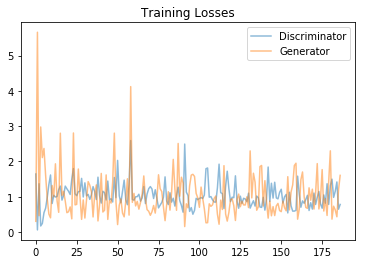

In [52]:
losses_mnist = np.array(losses_mnist)
losses_discriminator = [i[0] for i in losses_mnist.T[0]]
losses_generator = [i[1] for i in losses_mnist.T[0]]

fig, ax = pyplot.subplots()
pyplot.plot(losses_discriminator, label='Discriminator', alpha=0.5)
pyplot.plot(losses_generator, label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 4.0189... Generator Loss: 0.0384
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 1.7795
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 2.2744
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 0.2817... Generator Loss: 2.0288
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.0835... Generator Loss: 3.8483
Epoch 1/1... Discriminator Loss: 0.2423... Generator Loss: 2.5288


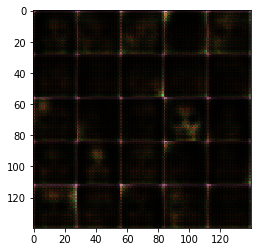

Epoch 1/1... Discriminator Loss: 0.4639... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 2.7982
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 3.2047
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 1.5157
Epoch 1/1... Discriminator Loss: 3.0515... Generator Loss: 0.1004
Epoch 1/1... Discriminator Loss: 1.0658... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 2.2104
Epoch 1/1... Discriminator Loss: 2.1196... Generator Loss: 0.2353
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.7608


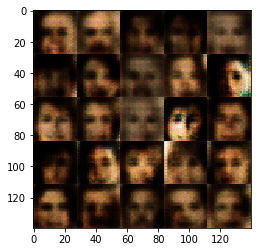

Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 3.5973
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 0.6014... Generator Loss: 2.5744
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 1.7475


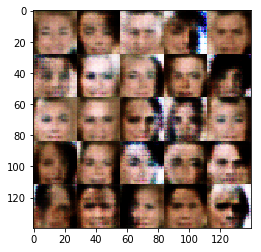

Epoch 1/1... Discriminator Loss: 0.4296... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 1.6880... Generator Loss: 0.2918
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.3941
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 1.8186
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.5739
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.7947


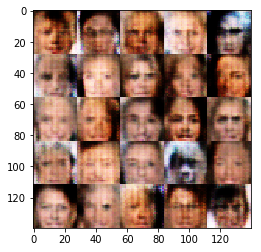

Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 5.4365
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.1132
Epoch 1/1... Discriminator Loss: 0.7876... Generator Loss: 1.1487
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 2.1305
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.6803
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 3.7012
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.4143
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 2.8635


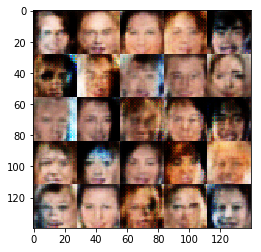

Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.4516
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 0.8527... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.8377
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.8423... Generator Loss: 0.2421
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 2.3591


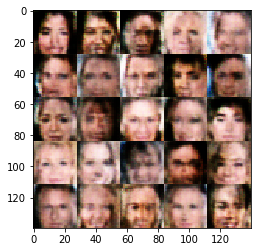

Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.1401
Epoch 1/1... Discriminator Loss: 1.8338... Generator Loss: 0.2530
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.0685
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 1.2646


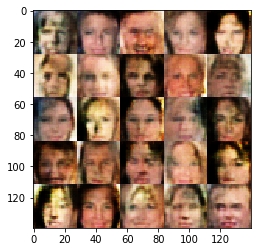

Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.2479
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.2961
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.4112
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 0.9448


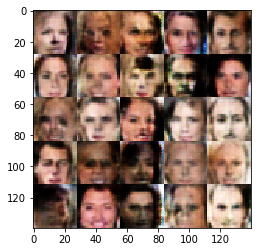

Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 1.3521
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 2.5082
Epoch 1/1... Discriminator Loss: 0.6883... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.3750
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.4875


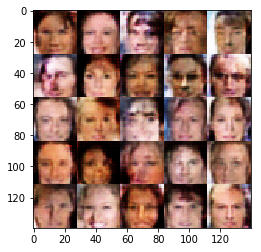

Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.3295
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.2247
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.4114


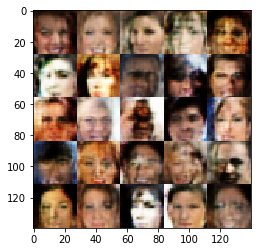

Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.2644
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 0.4004... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.5061
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.5910


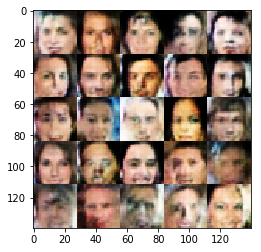

Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 1.9791
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 2.3435
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.4084
Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.2504


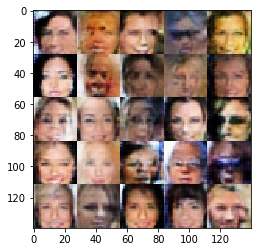

Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 1.3719
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.4986
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 0.5817... Generator Loss: 1.5064


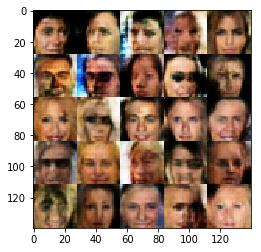

Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 2.2885
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.2677
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 2.6259
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.7527... Generator Loss: 0.2396
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6123


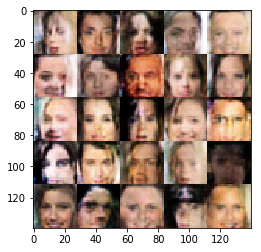

Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 2.0598
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.4068
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.3537
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.2889
Epoch 1/1... Discriminator Loss: 2.2300... Generator Loss: 2.8221
Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.5420
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 0.9643


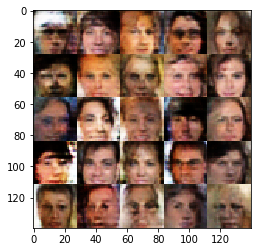

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5262
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 0.7516... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 0.8535... Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 0.9237


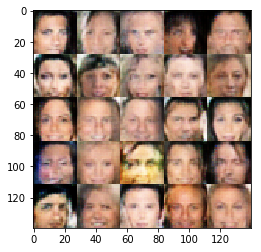

Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 1.1854
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.8351... Generator Loss: 0.2309
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 1.3957
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.7753


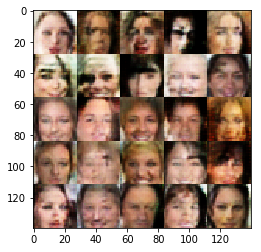

Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.9709
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.0529
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 2.3682
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.4150
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.8641


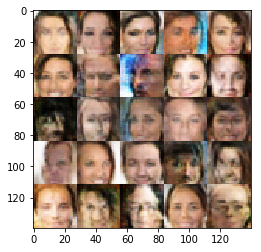

Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.0156... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 0.8477... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.3609
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 1.0798
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.0706


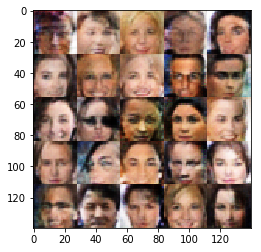

Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.5225
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 1.1947
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.3857


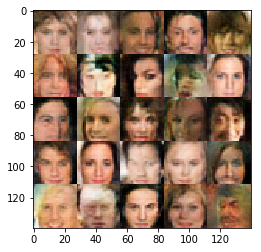

Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.2788
Epoch 1/1... Discriminator Loss: 1.5384... Generator Loss: 0.3533
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.7087... Generator Loss: 0.2653
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.5619
Epoch 1/1... Discriminator Loss: 1.7436... Generator Loss: 0.2608
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 0.9355


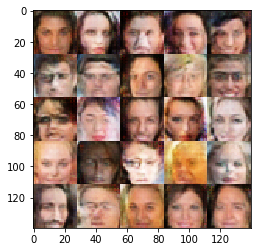

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.2930
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.5958... Generator Loss: 1.9415
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 0.7489... Generator Loss: 1.3811


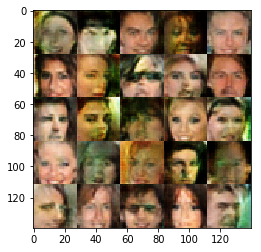

Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.3943
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.4203
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.0828
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 1.3729
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 1.3084


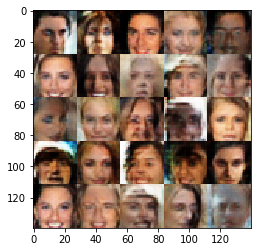

Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 1.0814


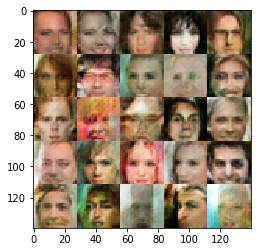

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.4180
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.4114
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.0739... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.8962


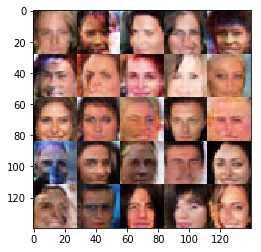

Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.3729
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.4967
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5240
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.9070
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.6631


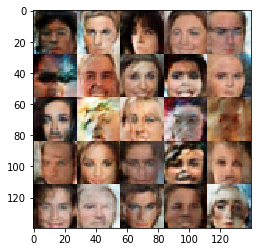

Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.3769
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.3603
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.4628
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4216
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.3862
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.5069
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.1208


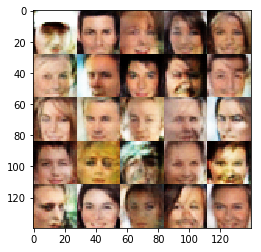

Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.7847... Generator Loss: 0.2736
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.2877
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7189


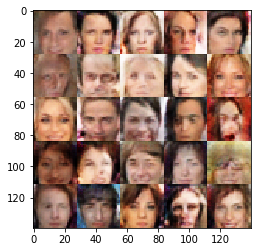

Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.3161
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.4383
Epoch 1/1... Discriminator Loss: 1.7769... Generator Loss: 0.2712
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.5490
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.7108... Generator Loss: 0.2644
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.2960


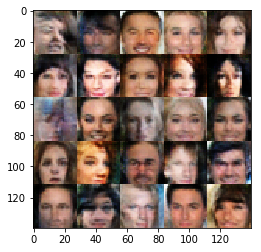

Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.5205... Generator Loss: 0.3324
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.7762


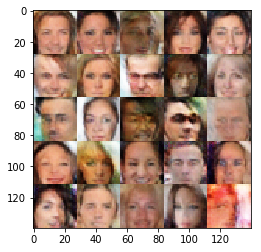

Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.8089... Generator Loss: 0.2597
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.0733
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.4226
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.9911


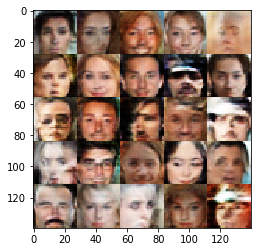

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.3972
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.6337
Epoch 1/1... Discriminator Loss: 1.7214... Generator Loss: 0.2653
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.3642
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.4765


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses_celeba = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

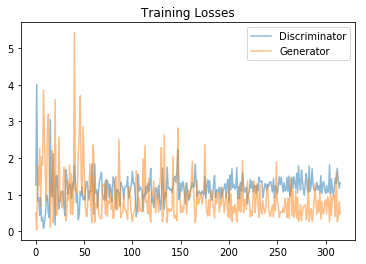

In [53]:
losses_celeba = np.array(losses_celeba)
losses_discriminator = [i[0] for i in losses_celeba.T[0]]
losses_generator = [i[1] for i in losses_celeba.T[0]]

fig, ax = pyplot.subplots()
pyplot.plot(losses_discriminator, label='Discriminator', alpha=0.5)
pyplot.plot(losses_generator, label='Generator', alpha=0.5)
pyplot.title("Training Losses")
pyplot.legend()

From the above two figures, the training losses looks meaningless. How to identify the performances of trained network with losses in this project? The only thing I could do is to see qualities of the generated pictures....

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.